In [4]:
# General data manipulation
import pandas
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import sys
import pandas as pd
from PIL import Image # pip install pillow
import gc
import os
from os import listdir
from os.path import isfile, join 
if os.getcwd() != '/home/azureuser/IDAO_2021':
    os.chdir('/home/azureuser/IDAO_2021')

In [162]:
# Deep learning setup (NN, CNN)
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Conv2D

Using TensorFlow backend.


In [6]:
DIR = os.getcwd() + '/idao_dataset'

In [7]:
# get train file names and convert to dataframe
# you may need to change your working directory first:
# os.chdir('/your_path')
ER_file_names = os.listdir(DIR + '/train/ER/')
NR_file_names = os.listdir(DIR + '/train/NR/')

ER = pd.DataFrame([[y.replace(';1.png','').replace('ev','') for y in x.split('_')] + [x] for x in ER_file_names])
NR = pd.DataFrame([[y.replace(';1.png','').replace('ev','') for y in x.split('_')] + [x] for x in NR_file_names])

# only few columns have distinct values
# print(ER.apply(lambda x: len(x.unique())))
# print(NR.apply(lambda x: len(x.unique())))

ER = ER[[5,6,0,15,16,17]].rename(columns={5:'type',6:'energy',0:'num',15:'run',16:'ev',17:'path'})
NR = NR[[6,7,0,17,18,19]].rename(columns={6:'type',7:'energy',0:'num',17:'run',18:'ev',19:'path'})
data = ER.append(NR, ignore_index=True)
data = data.astype(dict(zip(data.columns,[str,int,float,str,int,str])))
data['type_2'] = (data.type == 'ER')*1
data.head()

,type,energy,num,run,ev,path,type_2
0,ER,10,0.504150,run4,272,0.5041503310203552__CYGNO_60_40_ER_10_keV_930V...,1
1,ER,3,-0.137574,run3,449,-0.13757403194904327__CYGNO_60_40_ER_3_keV_930...,1
2,ER,10,0.504271,run5,882,0.5042710304260254__CYGNO_60_40_ER_10_keV_930V...,1
3,ER,30,-1.494719,run3,660,-1.4947187900543213__CYGNO_60_40_ER_30_keV_930...,1
4,ER,10,1.562488,run2,820,1.562488317489624__CYGNO_60_40_ER_10_keV_930V_...,1


In [11]:
def img2arr(img):
    return np.asarray(img.getdata(), dtype=np.uint8).reshape(img.height, img.width, -1)[:,:,0]

In [236]:
from scipy.ndimage import *
def getImg(Type,Energy,path='',k=288, shuffle=False, apply_filter=False):
    if not path:
        paths = list(data.loc[(data.type==Type)&(data.energy==Energy), 'path'])
        if shuffle:
            random.shuffle(paths)
        path = 'idao_dataset/train/'+Type+'/'+paths[0]
    img = Image.open(path).convert('LA')
    img = img2arr(img)[(288-k):(288+k), (288-k):(288+k)].astype(float)
    img -= np.median(img, axis=0)
    if apply_filter:
        img = grey_closing(gaussian_gradient_magnitude(img,5), 9)
    return img

In [274]:
N = 250
k = 64
img_list = []
target_data = []
trainTypeByEnergy = {'ER': [3,10,30], 'NR': [1,6,20]}
for Type in trainTypeByEnergy:
    for Energy in trainTypeByEnergy[Type]:
        print(Type, Energy)
        file_list = [DIR + '/train/' + data.type[i] + '/'+ data.path[i] for i in range(len(data)) if data.type[i]==Type and data.energy[i]==Energy]
        file_list = file_list[:N]
        for i in range(len(file_list)):
            img_list.append(getImg(Type, Energy, path=file_list[i], k=k, apply_filter=True))
        target_data += [int(Type=='ER')]*len(file_list)

ER 3
ER 10
ER 30
NR 1
NR 6
NR 20


In [275]:
img_array = np.array(img_list)
# img_array.shape
# reshape the matrix for CNN input
img_array = img_array.reshape(img_array.shape[0],128,128,1)
img_array.shape

(1500, 128, 128, 1)

In [276]:
# Train and Test data Split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    img_array, target_data, test_size=0.3)

# CNN for graphic data
#create model
model_1 = Sequential()
#add model layers
model_1.add(Conv2D(16, kernel_size=9, activation='relu', input_shape=(128,128,1)))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Conv2D(32, kernel_size=5, activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Conv2D(64, kernel_size=3, activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))
# model_1.add(Dense(1, activation='softmax'))


model_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

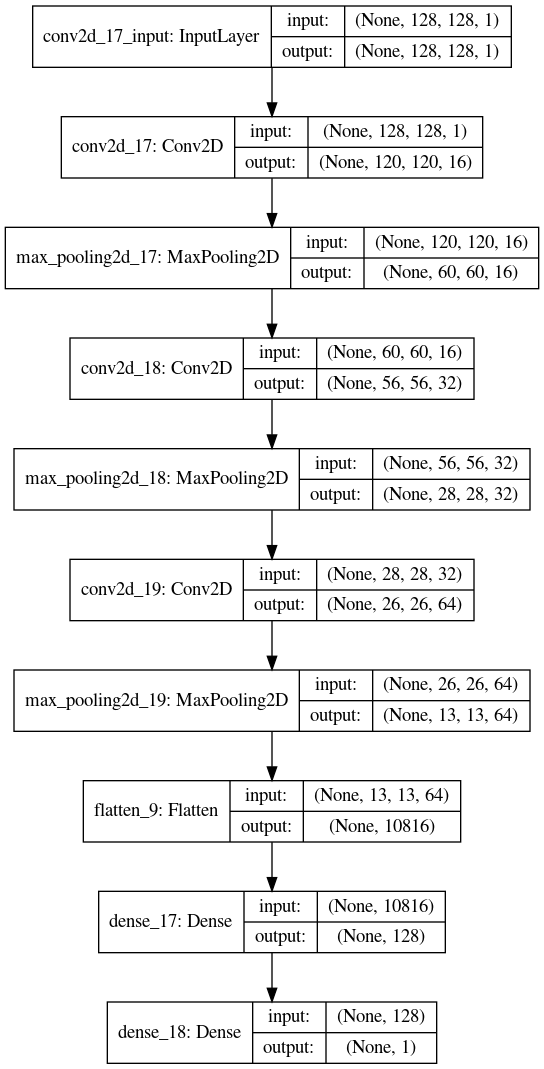

In [277]:
from keras.utils import plot_model
plot_model(model_1, show_shapes=True)

In [278]:
cnn_1 = model_1.fit(x_train, y_train,
          batch_size=50, epochs=10,
          # verbose=1,
          validation_data=(x_test, y_test))

Train on 1050 samples, validate on 450 samples
Epoch 1/10
1050/1050 [==============================] - 34s 33ms/step - loss: 0.6065 - accuracy: 0.6095 - val_loss: 0.5413 - val_accuracy: 0.7267
Epoch 2/10
1050/1050 [==============================] - 33s 32ms/step - loss: 0.4738 - accuracy: 0.8276 - val_loss: 0.3713 - val_accuracy: 0.8956
Epoch 3/10
1050/1050 [==============================] - 33s 32ms/step - loss: 0.1976 - accuracy: 0.9467 - val_loss: 0.0703 - val_accuracy: 0.9778
Epoch 4/10
1050/1050 [==============================] - 33s 31ms/step - loss: 0.0520 - accuracy: 0.9876 - val_loss: 0.0648 - val_accuracy: 0.9733
Epoch 5/10
1050/1050 [==============================] - 33s 32ms/step - loss: 0.0282 - accuracy: 0.9952 - val_loss: 0.0085 - val_accuracy: 0.9978
Epoch 6/10
1050/1050 [==============================] - 33s 31ms/step - loss: 0.0046 - accuracy: 0.9990 - val_loss: 0.0139 - val_accuracy: 0.9956
Epoch 7/10
1050/1050 [==============================] - 33s 31ms/step - loss:

In [316]:
# model_1. save('my_model.h5')
from keras.models import load_model
model_1 == model_1

True

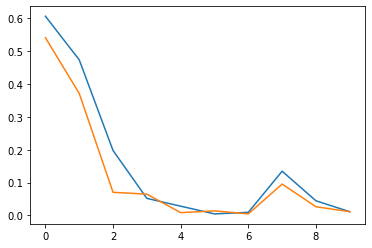

In [279]:
plt.plot(cnn_1.history['loss'])
plt.plot(cnn_1.history['val_loss'])

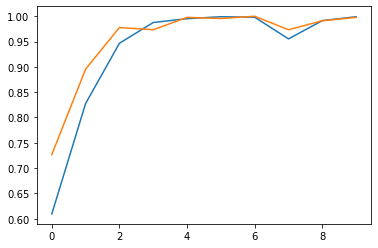

In [280]:
plt.plot(cnn_1.history['accuracy'])
plt.plot(cnn_1.history['val_accuracy'])

In [290]:
M = 10
in_sample = {'ER': [3,10,30], 'NR': [1,6,20]}
predicts_in = pd.DataFrame()
imgs_in = []
i = 0
for _ in range(M):
    for Type in in_sample:
        for Energy in in_sample[Type]:
            predicts_in = predicts_in.append(pd.DataFrame({'type':Type,'energy':Energy},index=[i]))
            i += 1
for i in range(len(predicts_in)):
    Type, Energy = predicts_in.iloc[i]
    img = getImg(Type, Energy, k=64, shuffle=True, apply_filter=True)
    imgs_in.append(img)
imgs_in = np.array(imgs_in).reshape((len(predicts_in),128,128,1))
predicts_in['predict']=['ER' if x==1 else 'NR' for x in model_1.predict(imgs_in).round()]
predicts_in['correct'] = predicts_in['type'] == predicts_in['predict']

In [291]:
predicts_in

,type,energy,predict,correct
0,ER,3,ER,True
1,ER,10,ER,True
2,ER,30,ER,True
3,NR,1,NR,True
4,NR,6,NR,True
5,NR,20,NR,True
6,ER,3,ER,True
7,ER,10,ER,True
8,ER,30,ER,True
9,NR,1,NR,True


In [292]:
print('Accuracy: %f' % (sum(predicts_in['correct'])/len(predicts_in)))
print(predicts_in)

Accuracy: 1.000000
   type  energy predict  correct
0    ER       3      ER     True
1    ER      10      ER     True
2    ER      30      ER     True
3    NR       1      NR     True
4    NR       6      NR     True
5    NR      20      NR     True
6    ER       3      ER     True
7    ER      10      ER     True
8    ER      30      ER     True
9    NR       1      NR     True
10   NR       6      NR     True
11   NR      20      NR     True
12   ER       3      ER     True
13   ER      10      ER     True
14   ER      30      ER     True
15   NR       1      NR     True
16   NR       6      NR     True
17   NR      20      NR     True
18   ER       3      ER     True
19   ER      10      ER     True
20   ER      30      ER     True
21   NR       1      NR     True
22   NR       6      NR     True
23   NR      20      NR     True
24   ER       3      ER     True
25   ER      10      ER     True
26   ER      30      ER     True
27   NR       1      NR     True
28   NR       6      NR 

In [300]:
out_sample = {'NR': [3,10,30], 'ER': [1,6,20]}
predicts_out = pd.DataFrame()
imgs_out = []
i = 0
for Type in out_sample:
    for Energy in out_sample[Type]:
        paths = [DIR + '/train/' + data.type[i] + '/'+ data.path[i] for i in range(len(data)) if data.type[i]==Type and data.energy[i]==Energy]
        for path in paths:
            img = getImg(Type, Energy, path=path, k=64, apply_filter=True)
            imgs_out.append(img)
            predicts_out = predicts_out.append(pd.DataFrame({'type': Type, 'energy': Energy}, index=[i]))
            i += 1
        
imgs_out = np.array(imgs_out).reshape((len(predicts_out),128,128,1))
predicts_out['predict']=['ER' if x==1 else 'NR' for x in model_1.predict(imgs_out).round()]
predicts_out['correct'] = predicts_out['type'] == predicts_out['predict']

In [301]:
print('Accuracy: %f' % (sum(predicts_out['correct'])/len(predicts_out)))
print(predicts_out)

Accuracy: 0.750000
   type  energy predict  correct
0    NR       3      NR     True
1    NR       3      NR     True
2    NR      10      NR     True
3    NR      10      NR     True
4    NR      30      NR     True
5    NR      30      NR     True
6    ER       1      NR    False
7    ER       1      NR    False
8    ER       1      NR    False
9    ER       6      ER     True
10   ER      20      ER     True
11   ER      20      ER     True


In [240]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import gc
if os.getcwd() != '/home/azureuser/IDAO_2021':
    os.chdir('/home/azureuser/IDAO_2021')

trainTypeByEnergy = {'NR': [6,20]}
flag = False
for Type in trainTypeByEnergy:
    for Energy in trainTypeByEnergy[Type]:
        print(Type, Energy)
        
        data = np.loadtxt('idao_dataset/train_csv/imgArrayData%s%d.csv' % (Type, Energy), delimiter=',', dtype=np.uint8)
        print(Type, Energy)
        data_mean = data.mean(axis=0)
        data_std = data.std(axis=0)
        data_mode, data_modeCnt = np.array(stats.mode(data))
        print(Type, Energy)
        data = data.flatten()
        aggMean = data.mean()
        aggStd = data.std()
        aggMode, aggModeCnt = np.array(stats.mode(data)).flatten()
        
        imgStats = np.concatenate([[data_mean], [data_std], data_mode, data_modeCnt], axis=0)
        imgStats = pd.concat([pd.DataFrame({'type':[Type]*4, 'energy':[Energy]*4, 'stat':['mean','std','mode','modeCnt'],
                                            'aggStat': [aggMean, aggStd, aggMode, aggModeCnt]}),
                              pd.DataFrame(imgStats)], axis=1)
        if flag:
            imgStats.to_csv('idao_dataset/train_csv/imgStats.csv', index=False)
        else:
            imgStats.to_csv('idao_dataset/train_csv/imgStats.csv', mode='a', header=False, index=False)
        del data, data_mean, data_std, data_mode, data_modeCnt, imgStats
        gc.collect()

NR 6


KeyboardInterrupt: 

In [135]:
imgStats = pd.read_csv('idao_dataset/train_csv/imgStats.csv')

In [82]:
imgStats[imgStats.columns.to_list()[:4]+[str(576*576//2+576//2)]]

,type,energy,stat,aggStat,166176
0,ER,3,mean,1.003972e+02,115.338386
1,ER,3,std,3.541390e+00,5.488210
2,ER,3,mode,1.000000e+02,115.000000
3,ER,3,modeCnt,1.069213e+08,168.000000
4,ER,10,mean,1.004097e+02,128.797975
5,ER,10,std,3.599975e+00,12.457291
6,ER,10,mode,1.000000e+02,127.000000
7,ER,10,modeCnt,1.082278e+08,83.000000
8,ER,30,mean,1.004494e+02,110.296379
9,ER,30,std,3.749697e+00,11.316523


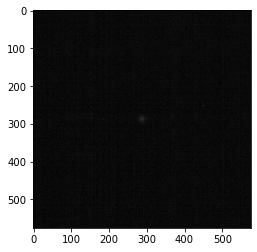

In [240]:
noise = imgStats.loc[(imgStats.stat=='mean')&(imgStats.type=='NR')&(imgStats.energy==1), 
                               imgStats.columns.to_list()[4:]]
noise = np.array(noise).reshape((576,576))
noise -= 100
plt.imshow(noise, cmap='gray', vmin=0, vmax=10)

In [222]:
def plotImgStats(stat, k, subtract_noise=False):
    trainTypeByEnergy = {'ER': [3,10,30], 'NR': [1]}
    i = 1
    fig=plt.figure(figsize=(12, 12))
    plt.suptitle(stat)
    for Type in trainTypeByEnergy:
        for Energy in trainTypeByEnergy[Type]:
            img = imgStats.loc[(imgStats.stat==stat)&(imgStats.type==Type)&(imgStats.energy==Energy), 
                               imgStats.columns.to_list()[4:]]
            img = np.array(img).reshape((576,576))
            if subtract_noise:
                img -= noise
            fig.add_subplot(3,2,i)
            plt.imshow(img[(288-k):(288+k), (288-k):(288+k)], cmap='gray', vmin=90, vmax=110)
            plt.title('%s %d' % (Type, Energy))
            i += 1

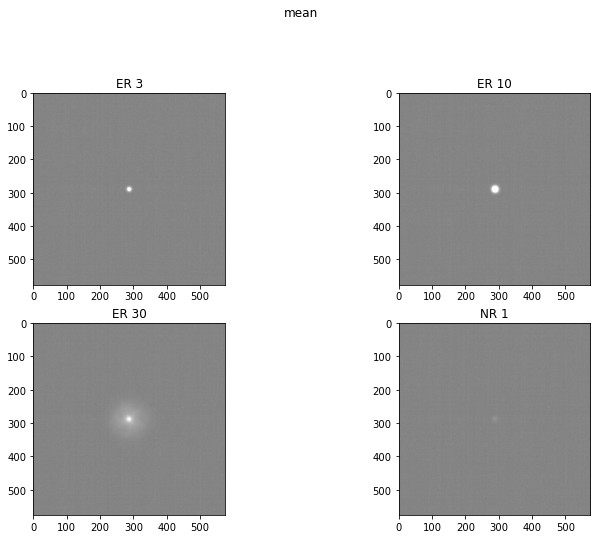

In [223]:
plotImgStats('mean', 288)

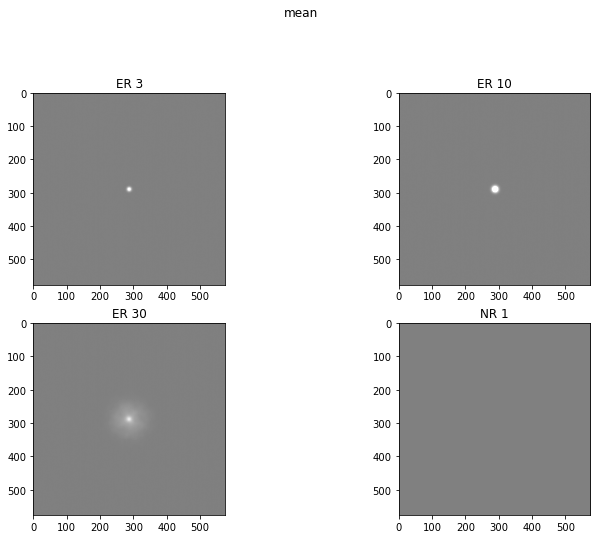

In [224]:
plotImgStats('mean', 288, subtract_noise=True)

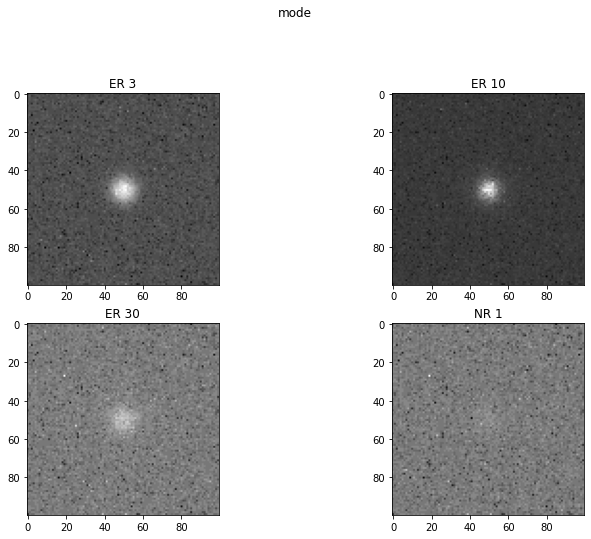

In [154]:
plotImgStats('mode', 50)

In [272]:
import random
from scipy.ndimage import *
def img2arr(img):
    return np.asarray(img.getdata(), dtype=np.uint8).reshape(img.height, img.width, -1)[:,:,0]

def mean_wo_outliner(a, q=0.95, axis=0):
    return (a * (a < np.quantile(a,q,axis=0))).sum(axis=0) / (a < np.quantile(a,q,axis=0)).sum(axis=0)

def plotImgExamples(cols, k, shuffle = False, img_filter=None, sigma=None, order=0, filter_size=None, vmin=None, vmax=None):
    fig=plt.figure(figsize=(16, 48))
    i = 1
    j = 0
    for Energy in [1,3,6,10,20,30]:
        for Type in ['ER', 'NR']:
            i = 1
            paths = list(data.loc[(data.type==Type)&(data.energy==Energy), 'path'])
            if shuffle:
                random.shuffle(paths)
            for path in paths:
                img = Image.open('idao_dataset/train/'+Type+'/'+path).convert('LA')
                fig.add_subplot(12,cols,j*cols+i)
                img = img2arr(img).astype(float)
#                 img -= mean_wo_outliner(img)
                img -= np.median(img, axis=0)
                if img_filter == gaussian_filter:
                    plt.imshow(img_filter(img,sigma,order=order)[(288-k):(288+k), (288-k):(288+k)], cmap='gray', vmin=vmin, vmax=vmax)
                elif img_filter == gaussian_gradient_magnitude:
                    plt.imshow(grey_closing(img_filter(img,sigma)[(288-k):(288+k), (288-k):(288+k)], filter_size), cmap='gray', vmin=vmin, vmax=vmax)
                elif img_filter == fourier_gaussian:
                    plt.imshow(np.fft.ifft2(fourier_gaussian(np.fft.fft2(img),sigma)).real[(288-k):(288+k), (288-k):(288+k)], cmap='gray', vmin=vmin, vmax=vmax)
                else:
                    plt.imshow(img[(288-k):(288+k), (288-k):(288+k)], cmap='gray', vmin=vmin, vmax=vmax)
#               plt.title('%s %d %.4f %.4f %.4f' % (Type, Energy, img.mean(), img.max(), img.std()))
                plt.title('%s %d' % (Type, Energy))
                i += 1
                if i > cols:
                    break
            j += 1

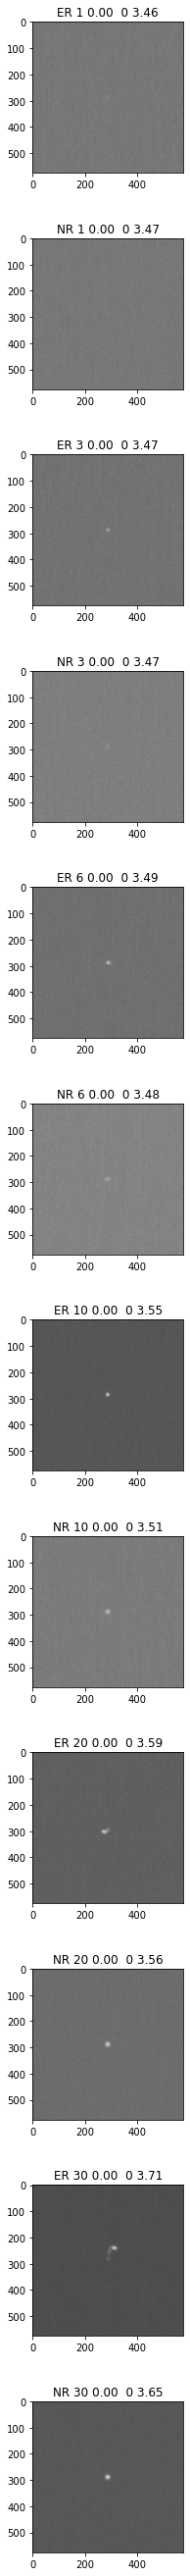

In [139]:
plotImgExamples(5, 288)

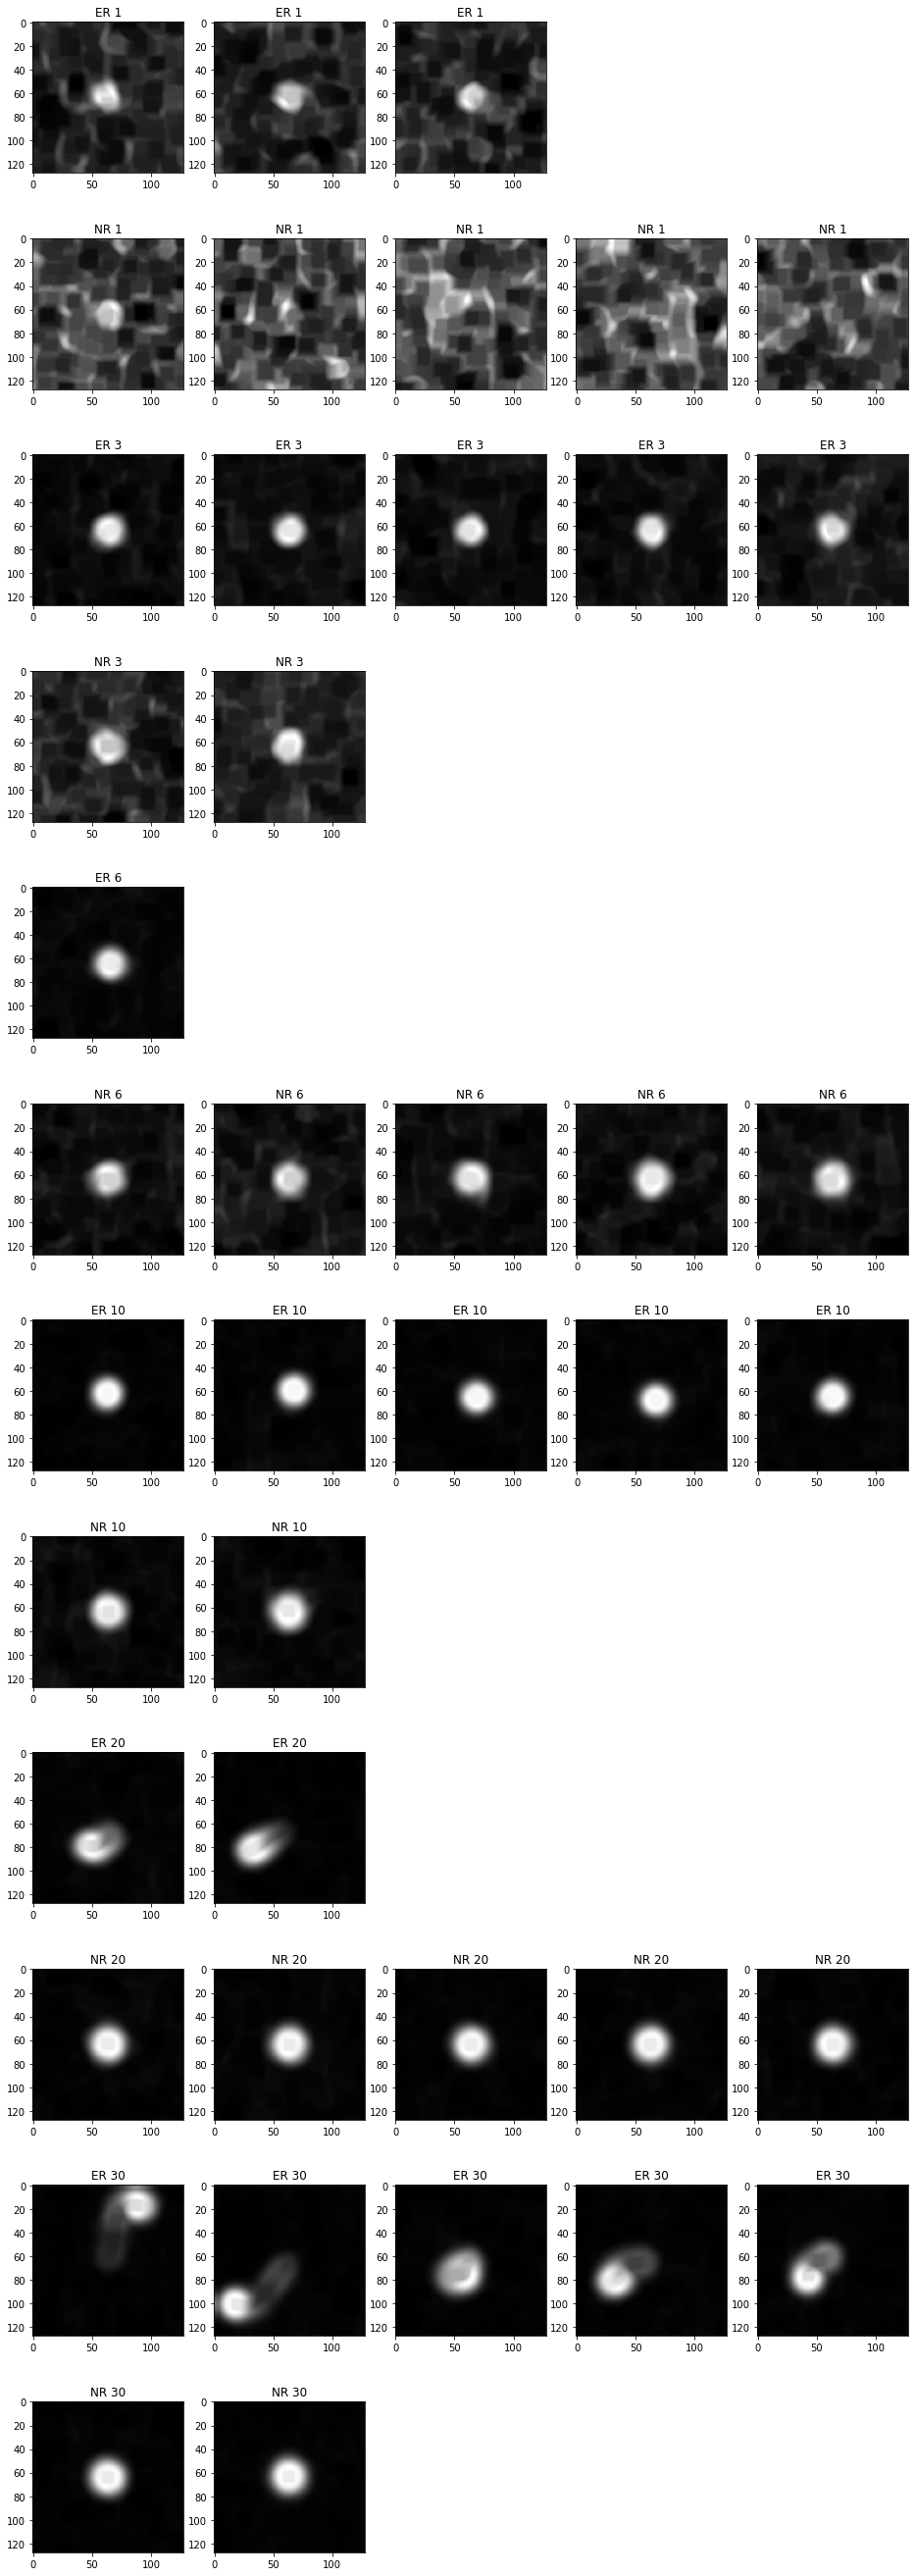

In [122]:
plotImgExamples(5, 64, img_filter=gaussian_gradient_magnitude, sigma=5, filter_size=9)

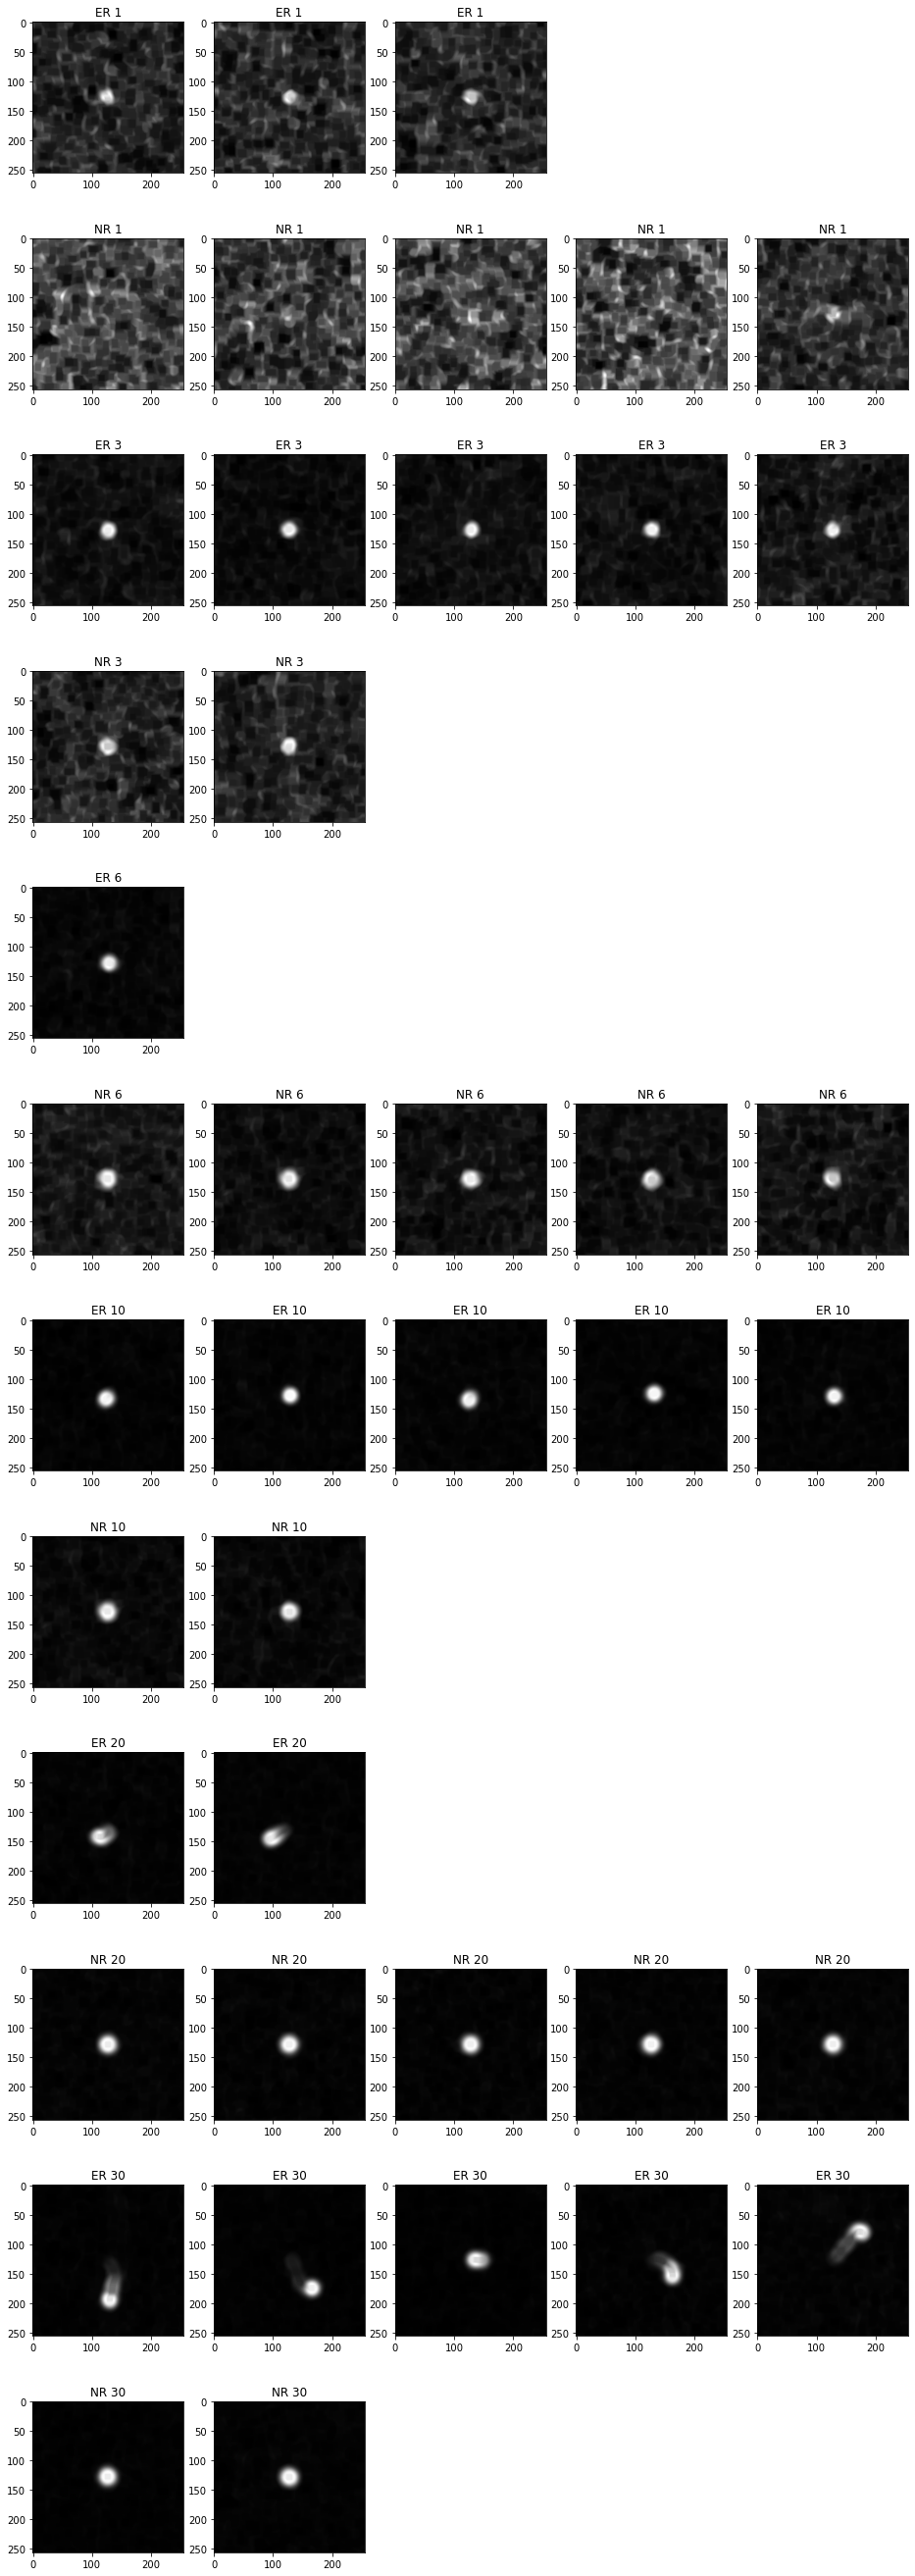

In [273]:
plotImgExamples(5, 128, img_filter=gaussian_gradient_magnitude, sigma=5, filter_size=9, shuffle=True)

In [211]:
ER1 = getImg('ER', 1)
NR1 = getImg('NR', 1)

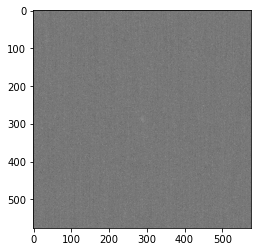

In [210]:
plt.imshow(ER1, cmap='gray')

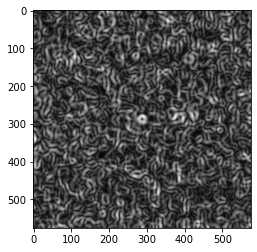

In [61]:
plt.imshow(gaussian_gradient_magnitude(NR1, 5), cmap='gray')

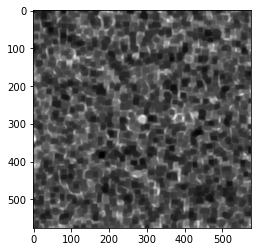

In [70]:
plt.imshow(grey_closing(gaussian_gradient_magnitude(NR1, 5),9), cmap='gray')

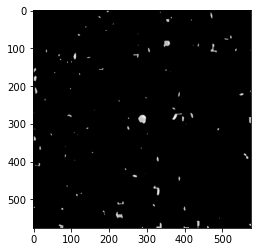

In [130]:
plt.imshow(grey_closing(gaussian_gradient_magnitude(NR1, 5),9) * (grey_closing(gaussian_gradient_magnitude(NR1, 5),9) > np.quantile(grey_closing(gaussian_gradient_magnitude(ER1, 5),9), 0.99)), cmap='gray')